# Imports

In [5]:
from data_pipeline import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
df_bpi = pd.read_csv("BPI_Challenge_2017.csv")

# Loading data and initial column renaming

In [7]:
# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

# df_bpi= pd.read_csv("BPI_Challenge_2017.csv")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')


# Running Pipeline

In [8]:
(X_train_pre, 
 y_train_pre, 
 X_test_pre, 
 y_test_pre, 
 X_train_post, 
 y_train_post, 
 X_test_post, 
 y_test_post, 
 X_train_total, 
 y_train_total, 
 X_test_total, 
 y_test_total) = pipeline(df_bpi, event_of_interest)

Starting pipeline...


Creating prefixes: 100%|██████████| 31509/31509 [02:01<00:00, 258.92it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...


C:\Users\20203666\Documents\GitHub\Advanced_PM_Group14\deliverable_group_14_phase_4\data_pipeline.py:280: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['call time'].fillna(0, inplace=True) #change None values to 0
C:\Users\20203666\Documents\GitHub\Advanced_PM_Group14\deliverable_group_14_phase_4\data_pipeline.py:280: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set

Performing frequency encoding...
Creating final X and Y datasets...
Doing the train-test split...
After filtering train-test split 79.82757496031833% train data and 20.172425039681677% test data
Converted column 'prefix_length' to int8.
Converted column 'event_of_interest_occured' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_freq' to int8.
Converted column 'A_Validating_freq' to int8.
Converted column 'O_Returned_freq' to int8.
Converted column 'W_Call in

# Define function for plotting evaluation insights

In [9]:
def plot_evaluation_insights(y_test, y_pred, y_pred_proba):
    # -----------------------------------
    # Model Evaluation
    # -----------------------------------

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Train and evaluate naive baseline

In [10]:
def make_naive_baseline(y_train, y_test):
    a_canceled_proportion = float((y_train.sum() / len(y_train)).iloc[0])
    y_naive_baseline = [1 if random.random() < a_canceled_proportion else 0 for _ in range(len(y_test))]
    # Probabilities are constant for all predictions (Is this correct?)
    y_probabilities = [a_canceled_proportion] * len(y_test)
    return y_naive_baseline, y_probabilities

y_naive_pre, y_proba_naive_pre = make_naive_baseline(y_train_pre, y_test_pre)
y_naive_post, y_proba_naive_post = make_naive_baseline(y_train_post, y_test_post)

Accuracy: 0.6764
ROC AUC: 0.5000
Confusion Matrix:
[[149051  40747]
 [ 35191   9683]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    189798
           1       0.19      0.22      0.20     44874

    accuracy                           0.68    234672
   macro avg       0.50      0.50      0.50    234672
weighted avg       0.69      0.68      0.68    234672



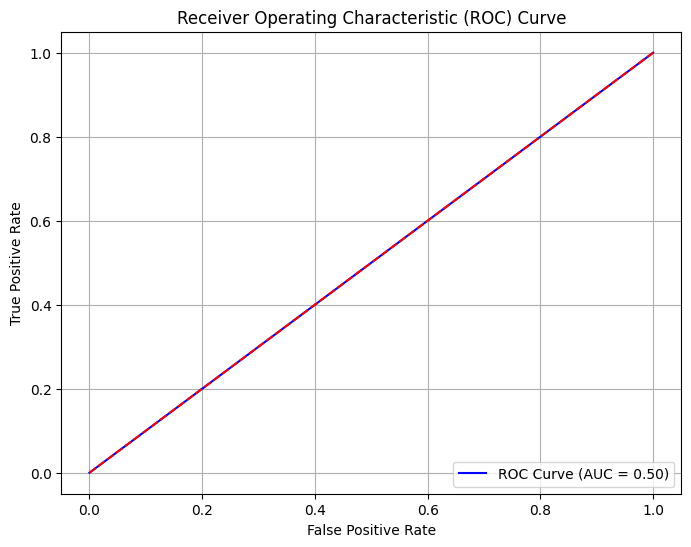

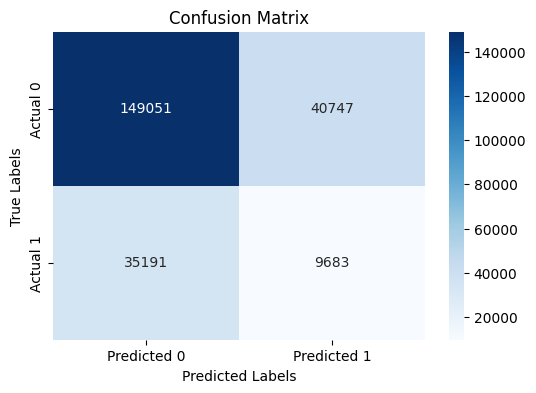

In [11]:
# This one we used for the rewards

y_naive_total, y_proba_naive_total = make_naive_baseline(y_train_total, y_test_total)
plot_evaluation_insights(y_test_total, y_naive_total, y_proba_naive_total)


# Define functions for training Random Forest model, obtaining predictions and feature importance

In [12]:
def balance_data(method, X_train, y_train):
    if method is None:
        return X_train, y_train
    elif method == "SMOTE":    
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    elif method == "ROS":  
        ros = RandomOverSampler(random_state=42)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:  # elif method == "RUS":
        rus = RandomUnderSampler(random_state=42)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    return X_train_balanced, y_train_balanced

In [13]:
def train_random_forest_model(X_train, y_train, class_weights=None, class_balancing_method=None):
    """
    class weights --> "balanced" or None for class weights
    class balancing method --> None, "SMOTE", "ROS", "RUS"
    """
    # Arrange class balancing
    X_train_balanced, y_train_balanced = balance_data(class_balancing_method, X_train, y_train)
    # Perform scaling
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both train and test sets
    X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight=class_weights,
        n_jobs=-1
    )

    # Train the model
    rf.fit(X_train_balanced_scaled, y_train_balanced)
    return rf, scaler  # return the trained model and the fitted scaler, to apply on testing data as well


def obtain_test_predictions(X_test, rf, scaler):
    # Make predictions
    X_test_scaled = scaler.transform(X_test)
    y_pred = rf.predict(X_test_scaled)
    y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
    return y_pred, y_pred_proba


def random_forest_feature_importance(X_train, rf):
    # -----------------------------------
    # Feature Importance
    # -----------------------------------

    # Extract feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Display top 10 features
    top_n = 10
    top_features = feature_importances_sorted.head(top_n)
    print(f"Top {top_n} Features:")
    print(top_features)

    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


# Train and evaluate the Post-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8691
ROC AUC: 0.9094
Confusion Matrix:
[[140427  12027]
 [ 11400  15153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    152454
           1       0.56      0.57      0.56     26553

    accuracy                           0.87    179007
   macro avg       0.74      0.75      0.74    179007
weighted avg       0.87      0.87      0.87    179007



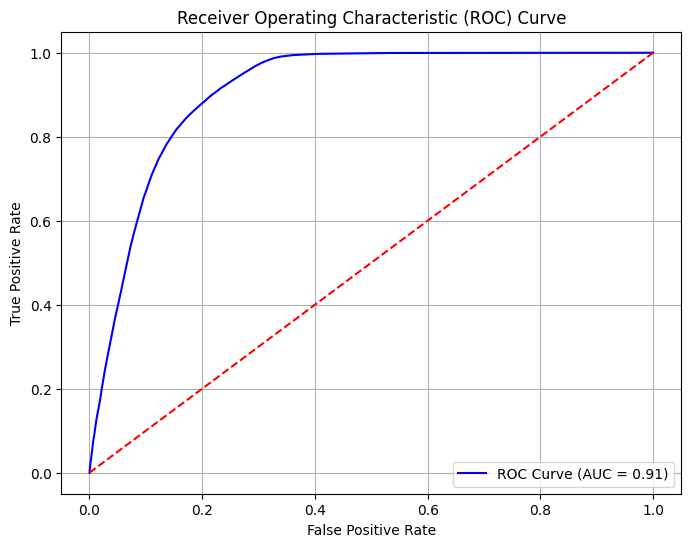

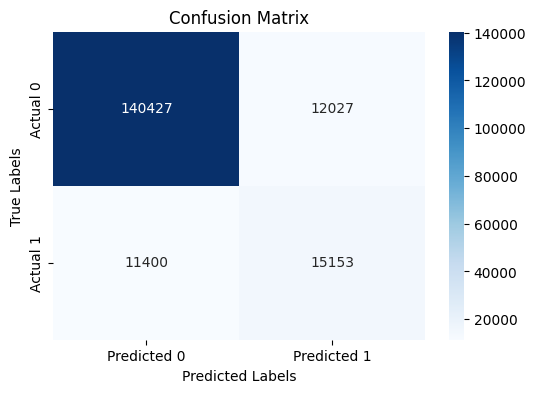

Top 10 Features:
CreditScore                    0.334929
total_time_prefix              0.068255
W_Validate application_freq    0.052852
MonthlyCost                    0.046164
prefix_average_time            0.044552
W_Call after offers_freq       0.038774
FirstWithdrawalAmount          0.038536
NumberOfTerms                  0.037183
OfferedAmount                  0.034358
A_Validating_freq              0.033630
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_23268\179953374.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


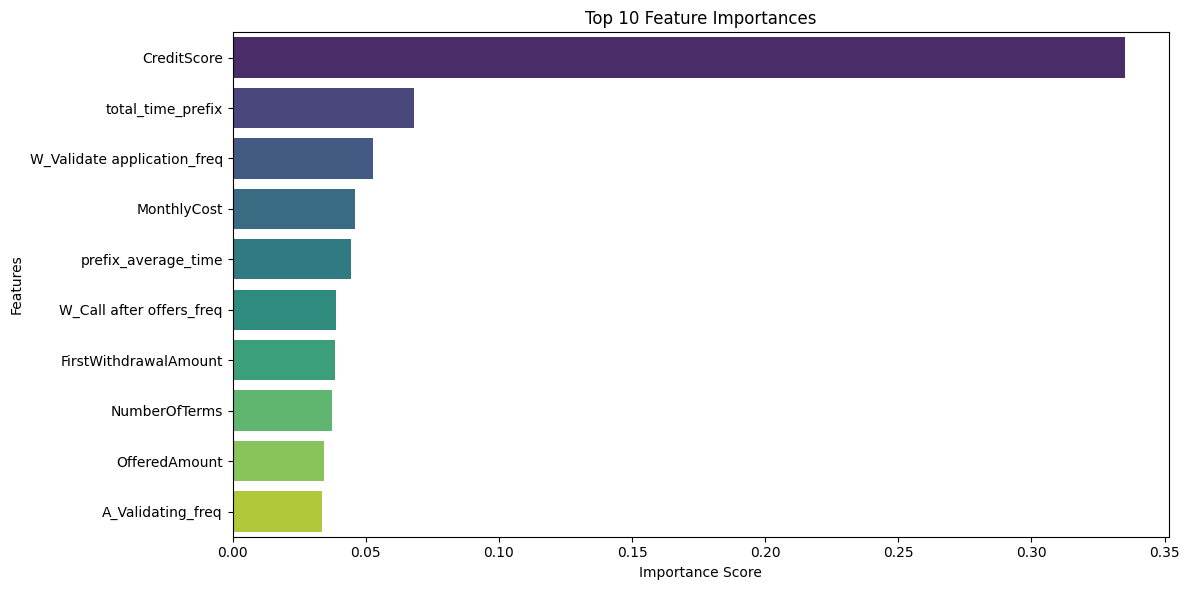

In [14]:
rf_post, scaler_post = train_random_forest_model(X_train_post, y_train_post, class_balancing_method='ROS')
y_pred_post, y_pred_proba_post = obtain_test_predictions(X_test_post, rf_post, scaler_post)
plot_evaluation_insights(y_test_post, y_pred_post, y_pred_proba_post)
random_forest_feature_importance(X_train_post, rf_post)

# Train and evaluate the Pre-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5768
ROC AUC: 0.5246
Confusion Matrix:
[[25531 11813]
 [11742  6579]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68     37344
           1       0.36      0.36      0.36     18321

    accuracy                           0.58     55665
   macro avg       0.52      0.52      0.52     55665
weighted avg       0.58      0.58      0.58     55665



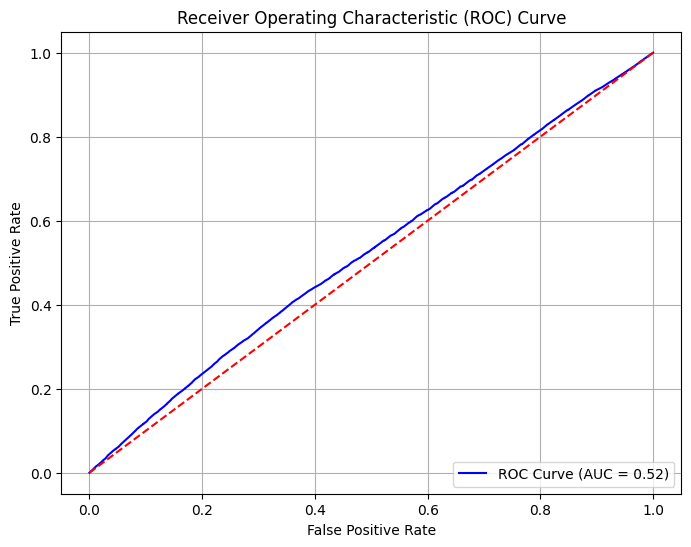

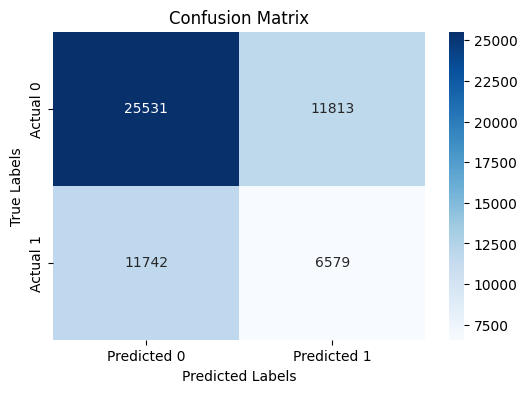

Top 10 Features:
prefix_average_time                 0.349269
total_time_prefix                   0.341848
case:RequestedAmount                0.189403
prefix_length                       0.025764
W_Complete application_freq         0.024001
W_Handle leads_freq                 0.018353
A_Submitted_freq                    0.005656
case:ApplicationType_New credit     0.005553
case:ApplicationType_Limit raise    0.004802
case:LoanGoal_Home improvement      0.004015
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_23268\179953374.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


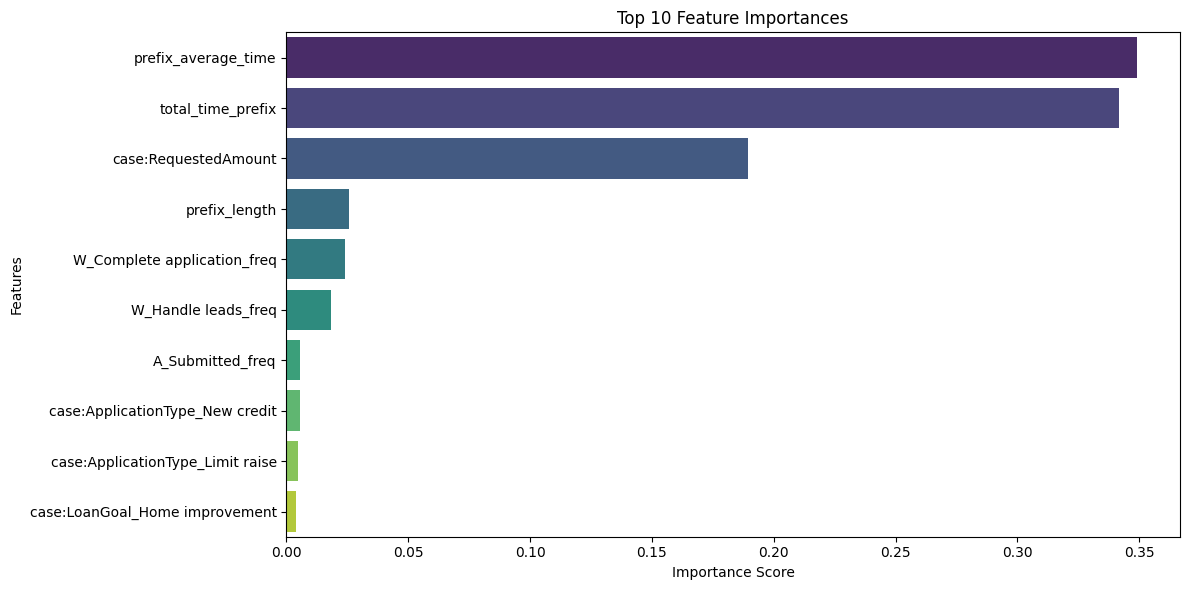

In [15]:
rf_pre, scaler_pre = train_random_forest_model(X_train_pre, y_train_pre, class_balancing_method="ROS")
y_pred_pre, y_pred_proba_pre = obtain_test_predictions(X_test_pre, rf_pre, scaler_pre)
plot_evaluation_insights(y_test_pre, y_pred_pre, y_pred_proba_pre)
random_forest_feature_importance(X_train_pre, rf_pre)

# make earliness plots

In [16]:
def make_accuracy_prefix_length_plot(X_test, y_test, rf, scaler, post_or_pre = 'post'):
    """
    Plot an earliness measure, showing the accuracy for different prefix lengths. 
    """
    test_df = X_test.join(y_test, how='left')
    prefix_accuracy_dict = {}
    for length in test_df['prefix_length'].unique():
        test_df_filtered = test_df[test_df['prefix_length']==length]
        y_pred_filtered, y_pred_proba_filtered = obtain_test_predictions(test_df_filtered.loc[:, test_df.columns != 'event_of_interest_occured'], rf, scaler)
        y_test_filtered = test_df_filtered.loc[:, test_df.columns == 'event_of_interest_occured']
        accuracy = np.mean(y_test_filtered['event_of_interest_occured'].tolist() == y_pred_filtered)
        prefix_accuracy_dict[length] = accuracy
        
    test_df['max_prefix_length'] = (test_df['prefix_length'] > test_df['prefix_length'].shift(1)) & (test_df['prefix_length'] > test_df['prefix_length'].shift(-1))

    mean_prefix_length = np.mean(test_df.loc[test_df['max_prefix_length'], 'prefix_length'].tolist())
    prefix_accuracy_dict = dict(sorted(prefix_accuracy_dict.items(), key=lambda item: item[0]))
    
    x = list(prefix_accuracy_dict.keys())
    y = list(prefix_accuracy_dict.values())
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_ylim(0.5,1.01)  # Sets the y-axis range to [0, 30]
    ax.axvline(x=mean_prefix_length, color='red', linestyle=':', linewidth=2)
    ax.set_xlabel('Prefix length')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy of the {post_or_pre} offer model against the prefix length')
    ax.grid(True)
    fig.show()

C:\Users\20203666\AppData\Local\Temp\ipykernel_23268\2773173487.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


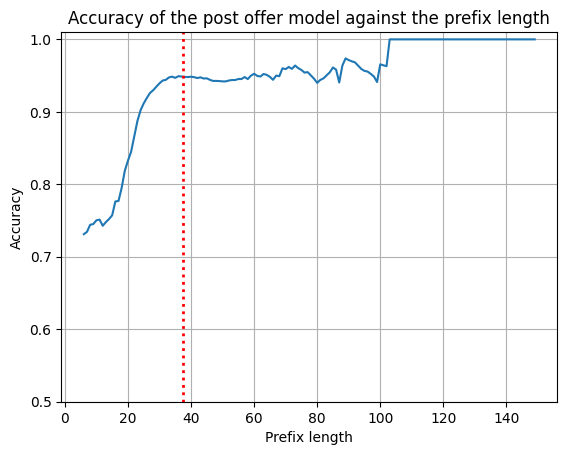

In [17]:
make_accuracy_prefix_length_plot(X_test_post, y_test_post, rf_post, scaler_post)

C:\Users\20203666\AppData\Local\Temp\ipykernel_23268\2773173487.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


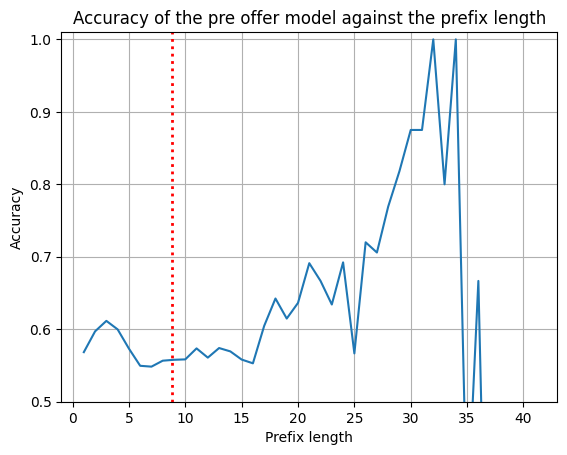

In [18]:
make_accuracy_prefix_length_plot(X_test_pre, y_test_pre, rf_pre, scaler_pre, post_or_pre="pre")

# Qualitative evaluation plot

In [19]:
pre, post = begin_pipeline_single_case(df_bpi, event_of_interest)

Starting pipeline...


Creating prefixes: 100%|██████████| 31509/31509 [01:57<00:00, 267.30it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...


C:\Users\20203666\Documents\GitHub\Advanced_PM_Group14\deliverable_group_14_phase_4\data_pipeline.py:280: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['call time'].fillna(0, inplace=True) #change None values to 0
C:\Users\20203666\Documents\GitHub\Advanced_PM_Group14\deliverable_group_14_phase_4\data_pipeline.py:280: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set

Performing frequency encoding...
Creating final X and Y datasets...
Converted column 'prefix_length' to int8.
Converted column 'event_of_interest_occured' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_freq' to int8.
Converted column 'A_Validating_freq' to int8.
Converted column 'O_Returned_freq' to int8.
Converted column 'W_Call incomplete files_freq' to int8.
Converted column 'A_Incomplete_freq' to int8.
Converted column 'O_Accepted_freq' to int8.
Convert

In [20]:
case = 'Application_391617926'
X_pre, y_pre, X_post, y_post = complete_pipeline_single_case(pre, post, case)
y_pred_pre, y_pred_proba_pre = obtain_test_predictions(X_pre, rf_pre, scaler_pre)
y_pred_post, y_pred_proba_post = obtain_test_predictions(X_post, rf_post, scaler_post)

Pipeline completed.


In [21]:
events = list(df_bpi[df_bpi['case']==case]['event'])[:-2]
y_pred_proba = list(y_pred_proba_pre) + list(y_pred_proba_post) + [1]

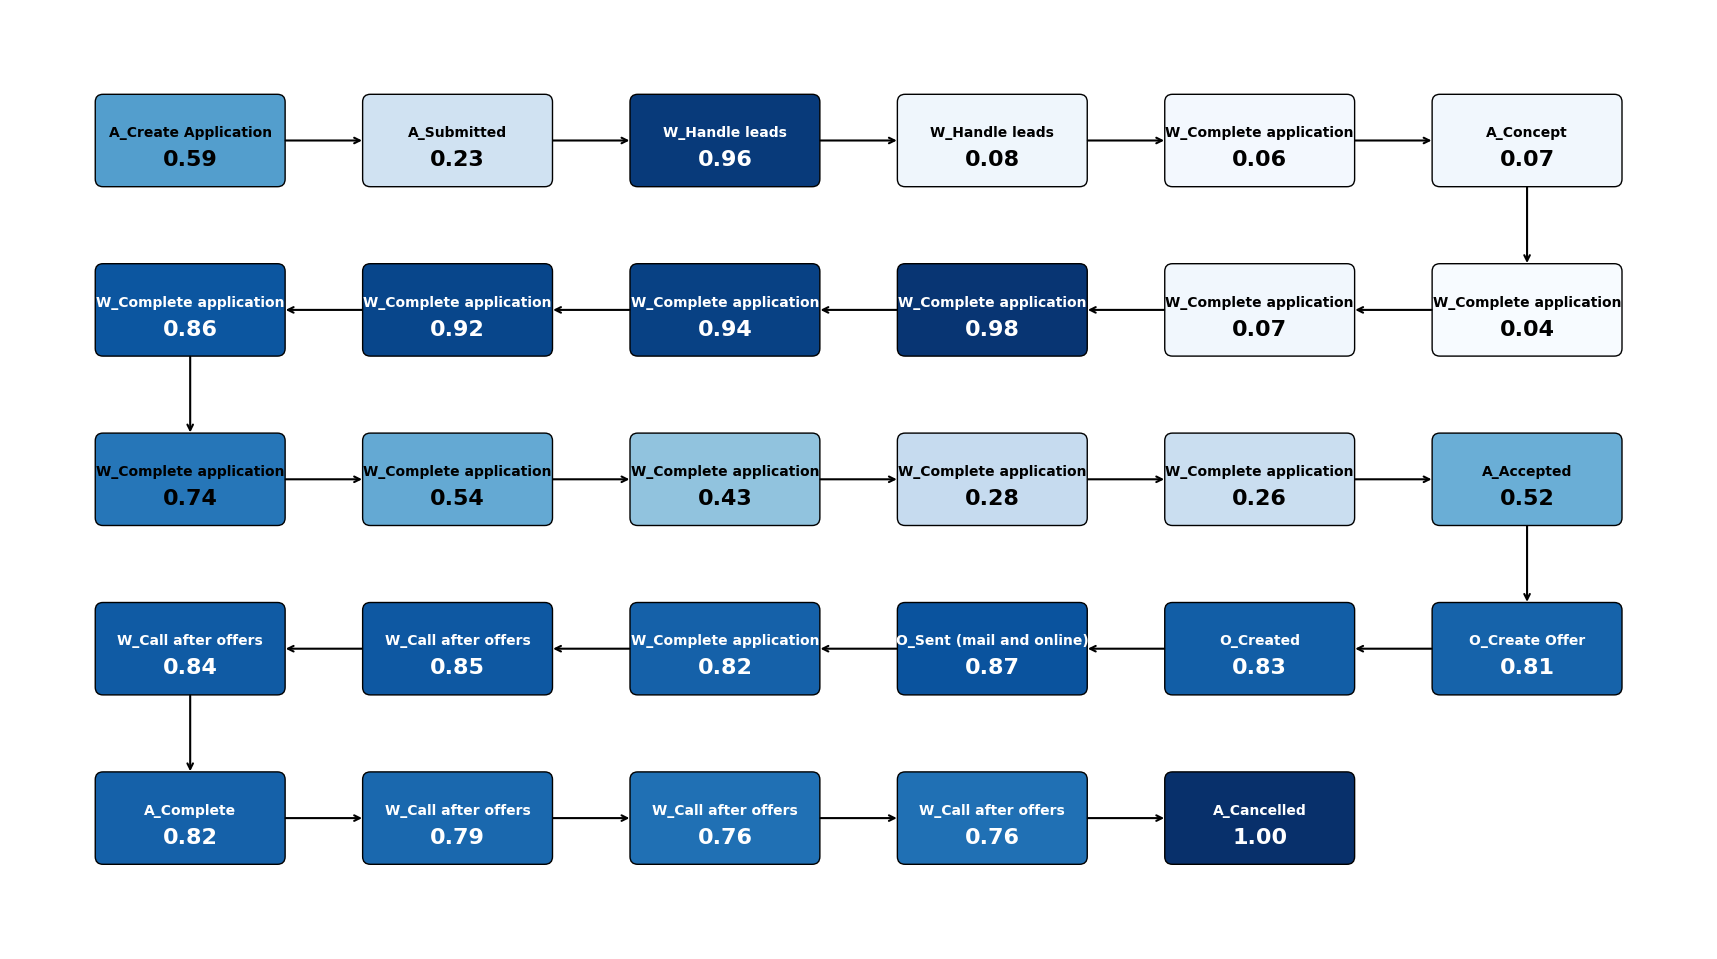

In [27]:
def plot_event_boxes_snake(events, probas):
    """
    Plots events in a snake layout using rectangular boxes,
    and draws arrows from box i to box i+1 using relevant edges.
    The event name and probability are displayed in separate text labels,
    allowing the probability font size to be larger.
    """
    n = len(events)
    if n == 0:
        print("No events to plot.")
        return

    # --- 1) Near-square layout dimensions ---
    num_cols = math.ceil(math.sqrt(n))
    num_rows = math.ceil(n / num_cols)

    # --- 2) Box & spacing parameters ---
    box_width = 2.25
    box_height = 1.0  # "less tall"
    x_margin = 1.2
    y_margin = 1.2

    # Figure size
    fig_width = num_cols * (box_width + x_margin) + x_margin
    fig_height = num_rows * (box_height + y_margin) + y_margin

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_xlim(0, fig_width)
    ax.set_ylim(0, fig_height)
    ax.axis('off')

    # --- 3) Normalize probabilities & pick colormap ---
    norm = plt.Normalize(min(probas), max(probas))
    cmap = plt.cm.Blues

    # We'll store each box’s edges so we can connect them with arrows
    edges = [{} for _ in range(n)]

    # --- 4) Place each event in a snake pattern ---
    for i, (event, proba) in enumerate(zip(events, probas)):
        # Determine row and column in the grid
        row = i // num_cols
        col = i % num_cols

        # Reverse columns on odd rows (snake effect)
        if row % 2 == 1:
            col = (num_cols - 1) - col

        # Bottom-left corner of this box (row=0 is top)
        x = x_margin + col * (box_width + x_margin)
        y = y_margin + (num_rows - 1 - row) * (box_height + y_margin)

        # Box color based on probability
        color = cmap(norm(proba))

        # Draw the box
        box_patch = patches.FancyBboxPatch(
            (x, y),
            box_width,
            box_height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black'
        )
        ax.add_patch(box_patch)

        # Choose text color if probability > 0.8
        text_color = 'white' if proba > 0.74 else 'black'

        # --- Separate text labels for event & probability ---
        # Event name in smaller font, near the top half
        ax.text(
            x + box_width / 2,
            y + box_height * 0.6,  # a bit above the center
            event,
            va='center',
            ha='center',
            color=text_color,
            fontsize=10,   # smaller font for event
            weight='bold'
        )

        # Probability in larger font, near the bottom half
        ax.text(
            x + box_width / 2,
            y + box_height * 0.25,  # a bit below the center
            f"{proba:.2f}",
            va='center',
            ha='center',
            color=text_color,
            fontsize=16,  # larger font size for probability
            weight='bold'
        )

        # Store edges for later arrow drawing
        edges[i]["left"]   = (x,              y + box_height/2)
        edges[i]["right"]  = (x + box_width,  y + box_height/2)
        edges[i]["top"]    = (x + box_width/2, y + box_height)
        edges[i]["bottom"] = (x + box_width/2, y)
        edges[i]["corner"] = (x, y)

    # --- 5) Draw arrows in sequence order ---
    for i in range(n - 1):
        # Current box's corner
        x_i, y_i = edges[i]["corner"]
        # Next box's corner
        x_j, y_j = edges[i + 1]["corner"]

        # If they are roughly on the same row
        if abs(y_j - y_i) < 1e-9:
            # Arrow from right of the left box to the left of the right box
            if x_j > x_i:
                start = edges[i]["right"]
                end   = edges[i + 1]["left"]
            else:
                start = edges[i]["left"]
                end   = edges[i + 1]["right"]
        elif y_j < y_i:
            # Next box is lower => arrow goes down from bottom -> top
            start = edges[i]["bottom"]
            end   = edges[i + 1]["top"]
        else:
            # Next box is higher => arrow goes up from top -> bottom
            start = edges[i]["top"]
            end   = edges[i + 1]["bottom"]

        # Draw arrow
        ax.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(
                arrowstyle="->",
                color="black",
                lw=1.5,
                shrinkA=6,
                shrinkB=6
            )
        )

    plt.show()

plot_event_boxes_snake(events, y_pred_proba)